Import librerie

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from lime import lime_text
import unicodedata
import pandas as pd
from string import punctuation
import numpy as np
import torch
from nltk.tokenize import word_tokenize
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
from tqdm import tqdm
from sklearn import preprocessing
import time
import random
import torch.nn.functional as F

In [9]:
language="english"
language_w="../input/fasttext-aligned-word-vectors/wiki.en.align.vec"


In [10]:
text="question_description"
review="ministry"
n_top_class=35
path_db="/kaggle/input/rajyasabha/rajyasabha_q*.{}"
import glob
import pandas as pd
extension = 'csv'
all_filenames = [i for i in glob.glob(path_db.format(extension))]
#combine all files in the list
df = pd.concat([pd.read_csv(f,encoding='latin1') for f in all_filenames ])



In [11]:
#text="testo"
#review="cap_maj_master"
#path_db="../input/ciao9cci/politica.xlsx"
#n_top_class=35
#df = pd.read_excel(path_db, sheet_name="Foglio1")

In [12]:
top_class=df.groupby(review).count()[[text]]
top_class=top_class.sort_values(by=[text], ascending=False).head(n_top_class)
top_class=top_class.apply(list).reset_index()
top_class = [d for d in top_class[review]]
print(top_class)

df=df.loc[df[review].isin(top_class)]
print(f'Found {len(df)} texts.')
print(f'{df[review].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df[review])]

df = df[df[text].str.split().str.len().gt(5)]

print(f'{df[text].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df[text])]

le = preprocessing.LabelEncoder()
le.fit(df[review])
df[review]=le.transform(df[review])
classes = [int(c) for c in df[review].values]
documents = [d for d in df[text]]

['HOME AFFAIRS', 'FINANCE', 'HEALTH AND FAMILY WELFARE', 'RAILWAYS', 'HUMAN RESOURCE DEVELOPMENT', 'AGRICULTURE', 'PETROLEUM AND NATURAL GAS', 'CIVIL AVIATION', 'CONSUMER AFFAIRS, FOOD AND PUBLIC DISTRIBUTION', 'LABOUR AND EMPLOYMENT', 'DEFENCE', 'EXTERNAL AFFAIRS', 'COMMUNICATION AND INFORMATION TECHNOLOGY', 'POWER', 'ROAD TRANSPORT & HIGH WAYS', 'ENVIRONMENT AND FORESTS', 'COMMERCE AND INDUSTRY', 'WOMEN AND CHILD DEVELOPMENT', 'RURAL DEVELOPMENT', 'COAL', 'LAW & JUSTICE', 'CHEMICALS AND FERTILIZERS', 'AGRICULTURE  AND FARMERS WELFARE', 'SOCIAL JUSTICE AND EMPOWERMENT', 'URBAN DEVELOPMENT', 'ENVIRONMENT, FOREST  AND CLIMATE CHANGE', 'COMMERCE AND INDUSTRY  ', 'INFORMATION AND BROADCASTING', 'TOURISM', 'CULTURE', 'PERSONNEL,PUBLIC GRIEVANCES AND PENSIONS', 'DRINKING WATER AND SANITATION', 'NEW AND RENEWABLE ENERGY', 'YOUTH AFFAIRS AND SPORTS', 'WATER RESOURCES']
Found 73756 texts.
0 document(s) with no classification removed
0 document(s) with no text removed


Import dataset

35


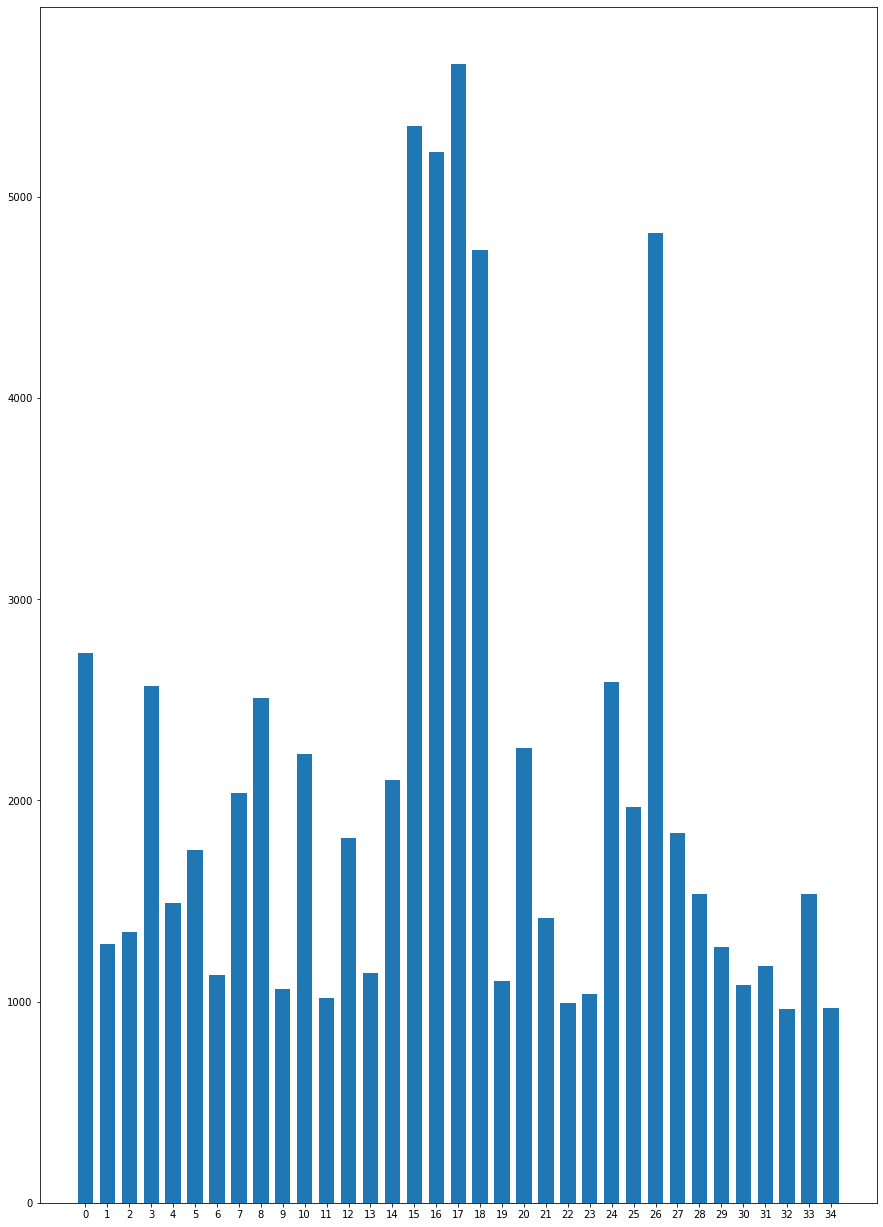

In [13]:
y = np.bincount(classes)
x = np.arange(len(y))
print(len(y))
fig, ax = plt.subplots(figsize=(15,22))
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()


preprocessing

In [14]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    #text = re.sub(r'[^\w\s]'," ", text)
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower().strip()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words(language))

def tokenizer_porter(text):
    word_tokens = word_tokenize(text)
    stemmer = SnowballStemmer(language, ignore_stopwords=True)
    return [stemmer.stem(word) for word in word_tokens]
  

def tokenizer(text):
    stop=set(stopwords.words(language))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_sentence = [w for w in filtered_sentence if len(w)>3]
    return filtered_sentence

In [15]:
def split_words_documents(documents):
    tokenized = documents = [tokenizer(strip_accents(preprocessor(document))) 
                              for document in documents]
    all_text = []
    for tokens in tokenized:
        for t in tokens:
            all_text.append(t)
    return tokenized, set(all_text)

documents, vocab = split_words_documents(documents)

KeyboardInterrupt: 

In [ ]:
print(np.max([len(x) for x in documents]))
print(np.mean([len(x) for x in documents]))
quant=np.quantile([len(x) for x in documents],.75)
print(quant)

In [ ]:
vocaboli=set(line.strip() for line in open('../input/prova2/prova.txt'))
vocaboli_more=vocaboli.union(vocab)
print("Aggiunte ",len(vocaboli_more)-len(vocaboli),"/",len(vocab)," parole")

In [ ]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i,w in enumerate(words)}
    int_to_word_dict = {i:w for w,i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict
word_to_int_dict, int_to_word_dict = create_dictionaries(vocaboli_more)

In [ ]:
def pad_text(tokenized_documents,seq_length):
    documents = []
    length=[]
    for document in tokenized_documents:
        if len(document) >= seq_length:
            documents.append(document[:seq_length])
            length.append(seq_length)
        else:
            length.append(len(document))
            documents.append(document+['']*(seq_length-len(document)))
    return np.array(documents),np.array(length)


In [ ]:
int_to_word_dict[0]=''
word_to_int_dict['']=0

In [ ]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.double)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [ ]:
# Load pretrained vectors
print("Tokenizing...\n")
embeddings = load_pretrained_vectors(word_to_int_dict, language_w)
embeddings = torch.tensor(embeddings)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE='cpu'
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

In [ ]:
def sort_batch(X,lengths,y):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X,lengths, y 

In [ ]:
def create_data_loader(train_c,train_len, valid_c, valid_len, train_l,valid_l,batch_size):
    x_train = torch.tensor(train_c, dtype=torch.long,device=DEVICE)
    x_train_len = torch.tensor(train_len, dtype=torch.long,device=DEVICE)
    y_train = torch.tensor(train_l, dtype=torch.long, device=DEVICE)
    x_cv = torch.tensor(valid_c, dtype=torch.long, device=DEVICE)
    x_cv_len = torch.tensor(valid_len, dtype=torch.long, device=DEVICE)
    y_cv = torch.tensor(valid_l, dtype=torch.long, device=DEVICE)
    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train,x_train_len, y_train)
    valid = torch.utils.data.TensorDataset(x_cv,x_cv_len, y_cv)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader
    

In [ ]:
def plot_graph(train_loss, valid_loss):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    #plt.ylim(0, 0.5) # consistent scale
    #plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import torch
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
class ClassificationCNN(nn.Module):
    
    def __init__(self, 
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 n_vocab=None, 
                 n_embed=300,
                 n_filters=100, 
                 n_output=1, 
                 filter_sizes=[2,3,4], 
                 dropout = 0.8,
                 pad_idx=0.0):
        super().__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.n_vocab, self.n_embed = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        
        
         
        self.dropout = nn.Dropout(dropout)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = self.n_embed, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        
        self.fc1 = nn.Linear(len(filter_sizes) * n_filters, n_filters)
        self.fc2 = nn.Linear(n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        

        
        
    def forward(self, text,len_text):
        
        emb = self.embedding(text)
        emb=emb.transpose(2,1)
        conved = [F.relu(c(emb)) for c in self.convs] 
        #al max_pool1d diamo come parametro il filter size
        pooled = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in conved]
        concat = self.dropout(torch.cat(pooled, dim = 1))
        out=self.fc1(concat)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [ ]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for i, (x_batch,len_batch, y_batch) in enumerate(data_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            logits= model(x_batch,len_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == y_batch).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

In [ ]:
def train(model, optimizer,criterion, train_loader, val_loader=None, patience=7, epochs=10):
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    best_accuracy=0
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        t0_epoch = time.time()
        total_loss = 0
        ###################
        # train the model #
        ###################
        model.train()
        for i, (x_batch,len_batch, y_batch) in enumerate(train_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            y_pred= model(x_batch,len_batch)
            # calculate the loss
            loss = criterion(y_pred, y_batch)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ###################### 
        valid_losses, val_accuracy = evaluate(model, val_loader,criterion)
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch :^7} | {train_loss:^12.6f} | {valid_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        
    print("\n")
    
    plot_graph(avg_train_losses, avg_valid_losses)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model
    

In [ ]:
def pytorch_predict(model, test_loader):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    labels=[]
    with torch.no_grad():
        for (text,length, label) in test_loader: 
            #text,length, label=sort_batch(text,length, label)
            outputs = model(text,length)
            _, preds = torch.max(outputs, 1)
            for pred in preds:
                labels.append(pred.item())
    
    return labels

In [ ]:
batch_size = 128
output_dim = len(np.unique(classes))
number_of_filters = 100
filter_sizes = [1,2,3]
dropout_pc = 0.5
n_epochs = 100
nfold=10
patience=5
lr = 1e-3

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

y=np.array(classes)
documents=np.array(documents)
kfold = StratifiedKFold(n_splits=nfold).split(documents, y)

accuracys = []
scores= []
metriche = np.zeros((nfold,4,output_dim))

#target_names=le.inverse_transform(target_names)

for k, (train_ids, test_ids) in enumerate(kfold):
    
    padded_sentences_train,lenght_train = pad_text(documents[train_ids], seq_length = int(quant))
    padded_sentences_test,lenght_test = pad_text(documents[test_ids], seq_length = int(quant))
    
    encoded_sentences_train = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_train])
    encoded_sentences_test  = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_test])
    
    print("train:",encoded_sentences_train.shape,"len:",lenght_train.size, "train_y:",y[train_ids].size)
    print("test:",encoded_sentences_test.shape,"len:",lenght_test.size)
    
    
    
    train_loader, val_loader=create_data_loader(encoded_sentences_train,lenght_train,
                                                encoded_sentences_test,lenght_test,
                                                y[train_ids],y[test_ids],batch_size)
    
    
    model = ClassificationCNN(
                        pretrained_embedding=embeddings, 
                        n_output=output_dim,
                        filter_sizes=filter_sizes,
                        dropout=dropout_pc,
                        n_filters=number_of_filters)
    model=model.double()
    loss_fn = nn.CrossEntropyLoss(reduction='sum').to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=lr,weight_decay=0.01)
    model.to(DEVICE)
    model=train(model,optimizer,loss_fn,train_loader,val_loader,patience,n_epochs)
    
    
    y_pred=pytorch_predict(model,val_loader)
    
    y_true=y[test_ids]
    
    target_names=np.unique(y[train_ids])
    accuracys.append(metrics.accuracy_score(y_true, y_pred))
    score=precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])
    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    dizionario=metrics.classification_report(y_true, y_pred, target_names=target_names,output_dict=True)
    for k_d,(m_id, m_info) in enumerate(dizionario.items()):
        if k_d<output_dim:
            for j_d,key in enumerate(m_info):
                metriche[k,j_d,k_d]=m_info[key]
        else:
            break
    
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=target_names , yticklabels=target_names )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

arr = np.array(scores)


In [ ]:
print("Overall results of the cross-validation procedure")
print()
print(f"{'Class':^7} | {'precision':^9}{'':^6} | {'recall':^10}{'':^5} | {'f1-measure':^6}{'':^5} | {'support':^9}")
for i in range(output_dim):
    print(f"{i :^7} | {np.mean(metriche[:,0,i])*100:^5.2f} +/-{np.std(metriche[:,0,i])*100:^6.2f} | {np.mean(metriche[:,1,i])*100:^5.2f} +/-{np.std(metriche[:,1,i])*100:^6.2f} | {np.mean(metriche[:,2,i])*100:^5.2f} +/-{np.std(metriche[:,2,i])*100:^6.2f} | {np.mean(metriche[:,3,i]):^9.2f}")
print()
print('\nCV accuracy: %.2f +/- %.2f max: %.2f' % (np.mean(accuracys)*100, np.std(accuracys)*100,np.max(accuracys)*100))
print('\nCV precision: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100,np.max(arr[:,0])*100))
print('\nCV recall: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100,np.max(arr[:,1])*100))
print('\nCV f1: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100,np.max(arr[:,2])*100))